In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
pd.options.display.max_rows = 999

import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
taxi = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Phân tích và trực quan dữ liệu/taxi_200k_head.csv')
taxi.rename(columns = {'Dropoff Centroid  Location': 'Dropoff Centroid Location'}, inplace=True) # có dư khoảng trắng trong tên cột
taxi.sample(5)

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
175862,582749dd44781245383df4dca4a9db690b51b12a,dbe719f61463e9a898d708225f0a49e2f0c3f7184cd51d...,01/07/2020 06:00:00 PM,01/07/2020 06:45:00 PM,3000.0,0.0,1.703198e+10,1.703108e+10,76.0,8.0,44.25,14.6,0.0,4.0,62.85,Credit Card,Taxi Affiliation Services,41.979071,-87.903040,POINT (-87.9030396611 41.9790708201),41.892042,-87.631864,POINT (-87.6318639497 41.8920421365)
156667,adcace50aac299a32fdce01b6e0dffdaae4d7f00,e585218a9f728ba533db40a74237a1caa23f01212f0fa8...,01/07/2020 10:00:00 AM,01/07/2020 10:15:00 AM,600.0,0.0,1.703108e+10,1.703128e+10,8.0,28.0,7.00,0.0,0.0,0.0,7.00,Cash,Blue Ribbon Taxi Association Inc.,41.893216,-87.637844,POINT (-87.6378442095 41.8932163595),41.885300,-87.642808,POINT (-87.6428084655 41.8853000224)
9108,a6e7ccd5e0e640c79af0b8ddbc059969b88c8071,d5fc0adc436b269c2ce07e37eff1af604a963c8538536b...,01/01/2020 07:45:00 AM,01/01/2020 08:00:00 AM,960.0,7.9,NaN,NaN,14.0,32.0,21.75,0.0,0.0,0.0,21.75,Cash,Taxi Affiliation Services,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.878866,-87.625192,POINT (-87.6251921424 41.8788655841)
37380,931bee6175d732eb90391ca71b56c6e887bee7bc,6c5a0fa721ea20077bbf38608238d3e7eddb67a9d18060...,01/02/2020 04:30:00 PM,01/02/2020 04:45:00 PM,489.0,1.0,1.703184e+10,1.703128e+10,32.0,28.0,6.50,0.0,0.0,0.0,6.50,Cash,City Service,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.879255,-87.642649,POINT (-87.642648998 41.8792550844)
84799,d635d949da0fa74e3c0788e7e7b6f02deed0d409,46182a244f8a81ba3c58545e7259ffe8ce0ade1911da25...,01/04/2020 12:45:00 PM,01/04/2020 12:45:00 PM,240.0,0.0,1.703108e+10,1.703108e+10,8.0,8.0,5.50,0.0,0.0,0.0,5.50,Cash,Blue Ribbon Taxi Association Inc.,41.893216,-87.637844,POINT (-87.6378442095 41.8932163595),41.890922,-87.618868,POINT (-87.6188683546 41.8909220259)


In [4]:
num_field = ['Trip Seconds','Trip Miles','Pickup Census Tract','Dropoff Census Tract','Pickup Community Area','Dropoff Community Area',
             'Fare','Tolls','Extras','Trip Total']
cat_field = ['Payment Type','Company']

In [5]:
# bộ dữ liệu hỗ trợ điền khuyết

tracts = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Phân tích và trực quan dữ liệu/CensusTractsTIGER2010.csv')
tracts = tracts[['GEOID10', 'COMMAREA']]
tracts.rename(columns={'GEOID10': 'tract', 'COMMAREA': 'area'}, inplace=True)
tracts.head()

,tract,area
0,17031842400,44
1,17031840300,59
2,17031841100,34
3,17031841200,31
4,17031839000,32


In [6]:
print(tracts.shape)
tracts.isna().sum()

(801, 2)


tract    0
area     0
dtype: int64

Từ trip start và trip end -> buổi sáng hay tối

Tìm hiểu taxi id giống nhau có điểm gì tương đồng

# EDA

In [7]:
taxi.describe()

,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude
count,199972.000000,199998.000000,1.120990e+05,1.111580e+05,186796.000000,181607.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,186969.000000,186969.000000,182097.000000,182097.000000
mean,769.691102,3.376774,1.703140e+10,1.703137e+10,27.094290,22.048643,14.359137,1.507596,0.002096,1.188594,17.171309,41.899877,-87.668567,41.897676,-87.651179
std,1719.639365,5.855607,3.431733e+05,3.281281e+05,21.795249,17.363435,69.851407,2.789146,0.156028,11.150761,71.410102,0.046862,0.085734,0.043382,0.053143
min,0.000000,0.000000,1.703101e+10,1.703101e+10,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.660136,-87.913625,41.660136,-87.913625
25%,313.000000,0.500000,1.703108e+10,1.703108e+10,8.000000,8.000000,5.750000,0.000000,0.000000,0.000000,7.000000,41.880994,-87.655998,41.880994,-87.655998
50%,536.000000,1.190000,1.703128e+10,1.703128e+10,28.000000,24.000000,7.750000,0.000000,0.000000,0.000000,9.500000,41.892042,-87.633308,41.892073,-87.633308
75%,900.000000,3.060000,1.703184e+10,1.703184e+10,32.000000,32.000000,14.500000,2.000000,0.000000,1.000000,16.750000,41.905858,-87.626211,41.907413,-87.626211
max,85741.000000,693.000000,1.703198e+10,1.703198e+10,77.000000,77.000000,8003.720000,200.000000,50.000000,4421.440000,8003.720000,42.021224,-87.534903,42.016046,-87.534903


## Kiểm tra có hàng trùng nhau

In [8]:
print(taxi.shape)
print(taxi.drop_duplicates().shape)

(200000, 23)
(200000, 23)


In [9]:
print('Có {} chiếc taxi hoạt động trong bộ dữ liệu.'.format(taxi['Taxi ID'].drop_duplicates().shape[0]))

Có 3711 chiếc taxi hoạt động trong bộ dữ liệu.


In [10]:
print('Có {} hãng taxi trong bộ dữ liệu.'.format(taxi['Company'].drop_duplicates().shape[0]))

Có 47 hãng taxi trong bộ dữ liệu.


## Kiểm tra missing values

In [11]:
taxi.isna().sum(axis=0)

Trip ID                           0
Taxi ID                           0
Trip Start Timestamp              0
Trip End Timestamp                0
Trip Seconds                     28
Trip Miles                        2
Pickup Census Tract           87901
Dropoff Census Tract          88842
Pickup Community Area         13204
Dropoff Community Area        18393
Fare                              0
Tips                              0
Tolls                             0
Extras                            0
Trip Total                        0
Payment Type                      0
Company                           0
Pickup Centroid Latitude      13031
Pickup Centroid Longitude     13031
Pickup Centroid Location      13031
Dropoff Centroid Latitude     17903
Dropoff Centroid Longitude    17903
Dropoff Centroid Location     17903
dtype: int64

Trip Seconds có dòng bị thiếu giá trị nên có thể xem xét việc điền khuyết dựa vào trip start và trip end

In [12]:
from plotly.offline import init_notebook_mode, iplot

def visual_percentage(field):
    temp = taxi[field].value_counts()
    fig = {
      "data": [
        {
          "values": temp.values,
          "labels": temp.index,
          "domain": {"x": [0, .48]},
          #"name": "Types of Loans",
          #"hoverinfo":"label+percent+name",
          "hole": .7,
          "type": "pie"
        },

        ],
      "layout": {
            "annotations": [
                {
                    "font": {
                        "size": 20
                    },
                    "showarrow": False,
                    "text": field,
                    "x": 0.17,
                    "y": 0.5
                }

            ]
        }
    }
    iplot(fig, filename='donut')

for col in cat_field:
  visual_percentage(col)

## Phân tích tương quan giữa các thuộc tính

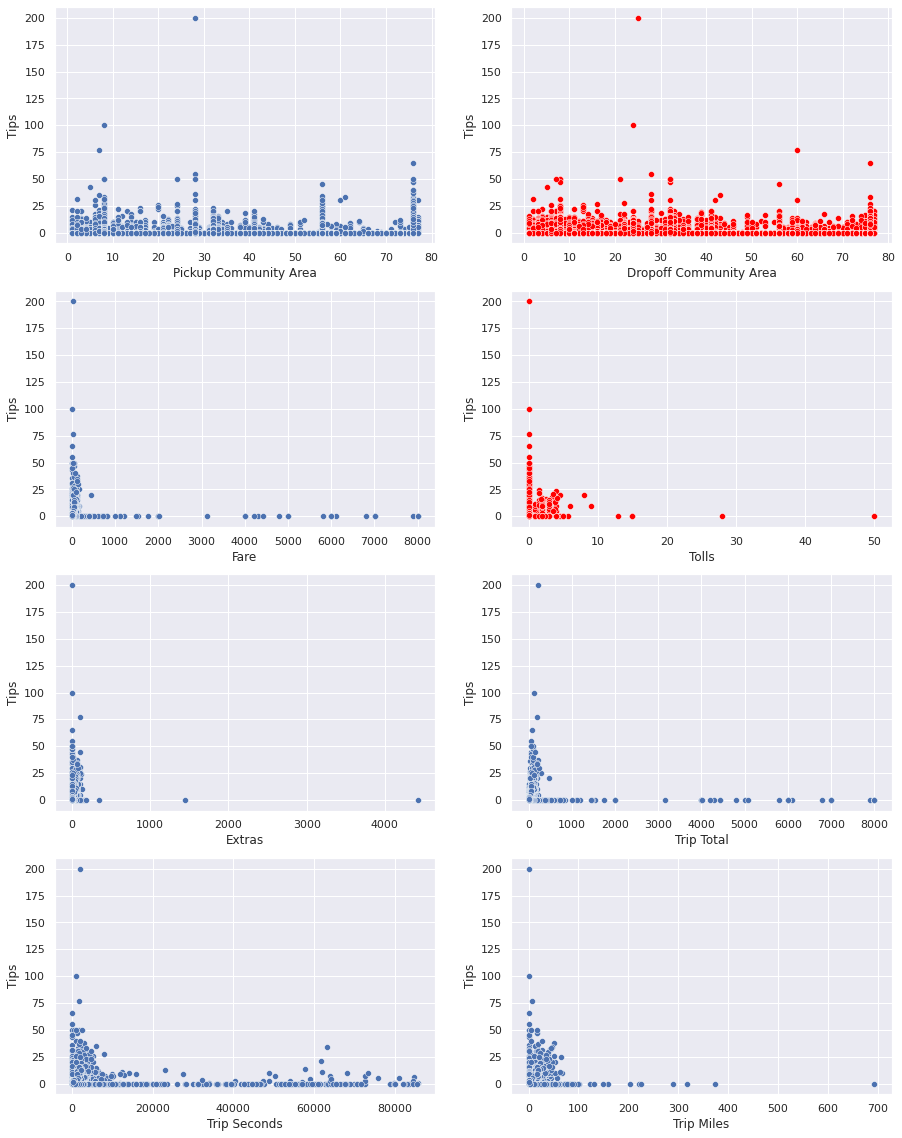

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,20))

sns.scatterplot(x=taxi['Pickup Community Area'],y=taxi['Tips'], ax=axes[0,0])
sns.scatterplot(x=taxi['Dropoff Community Area'],y=taxi['Tips'], ax=axes[0,1], color='red')
sns.scatterplot(x=taxi['Fare'],y=taxi['Tips'], ax=axes[1,0])
sns.scatterplot(x=taxi['Tolls'],y=taxi['Tips'], ax=axes[1,1], color='red')
sns.scatterplot(x=taxi['Extras'],y=taxi['Tips'], ax=axes[2,0])
sns.scatterplot(x=taxi['Trip Total'],y=taxi['Tips'], ax=axes[2,1])
sns.scatterplot(x=taxi['Trip Seconds'],y=taxi['Tips'], ax=axes[3,0])
sns.scatterplot(x=taxi['Trip Miles'],y=taxi['Tips'], ax=axes[3,1])


In [14]:
# Ti le tips theo phương thức thanh toán 
df_pay= pd.DataFrame()
df_pay['Payment Type']=['Cash', 'Credit Card', 'Dispute', 'Mobile', 'No Charge', 'Unknown','Prcard', 'Prepaid']
a = []
for i in list(['Cash', 'Credit Card', 'Dispute', 'Mobile', 'No Charge', 'Unknown','Prcard', 'Prepaid']):
  a.append((taxi[(taxi['Payment Type']==i) & (taxi['Tips']!=0)].shape[0])/taxi[(taxi['Payment Type']==i)].shape[0])
df_pay['value']=a
df_pay=df_pay.sort_values(by='value')

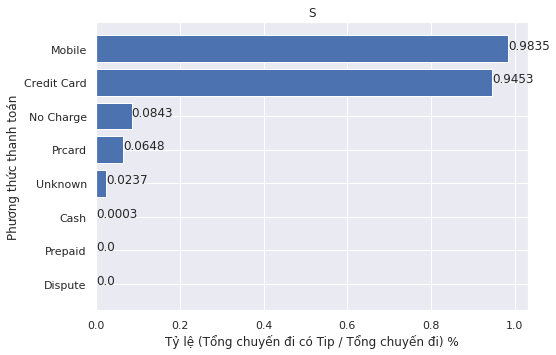

In [15]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = df_pay['Payment Type'].unique()
students = df_pay['value']
ax.barh(langs,students)
for index,value in enumerate(df_pay['value']):
  plt.text(value,index,str(round(value,4)))
plt.title('S')
plt.xlabel('Tỷ lệ (Tổng chuyến đi có Tip / Tổng chuyến đi) %')
plt.ylabel('Phương thức thanh toán');

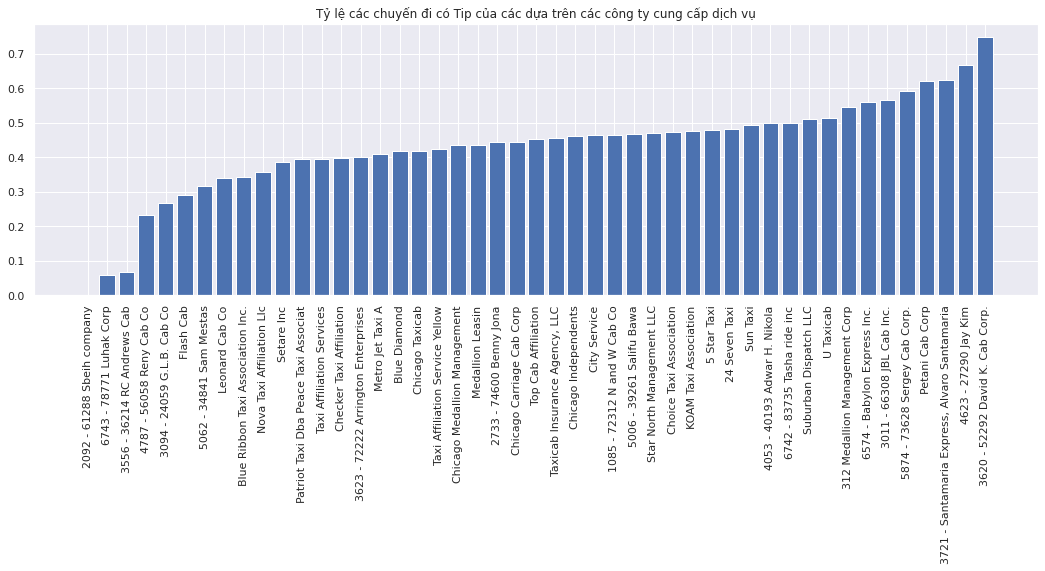

In [16]:
# Tỉ lệ tips theo  công ti
df_com= pd.DataFrame()
df_com['Company']=list(taxi['Company'].unique())
a = []
for i in list(df_com['Company']):
  a.append((taxi[(taxi['Company']==i) & (taxi['Tips']!=0)].shape[0])/taxi[(taxi['Company']==i)].shape[0])
df_com['value']=a
df_com=df_com.sort_values(by='value',ignore_index=True)

fig, ax1 = plt.subplots(1,1, figsize=(18, 5))
plt.bar(df_com['Company'],df_com['value'])
ax1.set_xticklabels(df_com['Company'], minor=False, rotation=90)
plt.title('Tỷ lệ các chuyến đi có Tip của các dựa trên các công ty cung cấp dịch vụ');

### Distribution plots

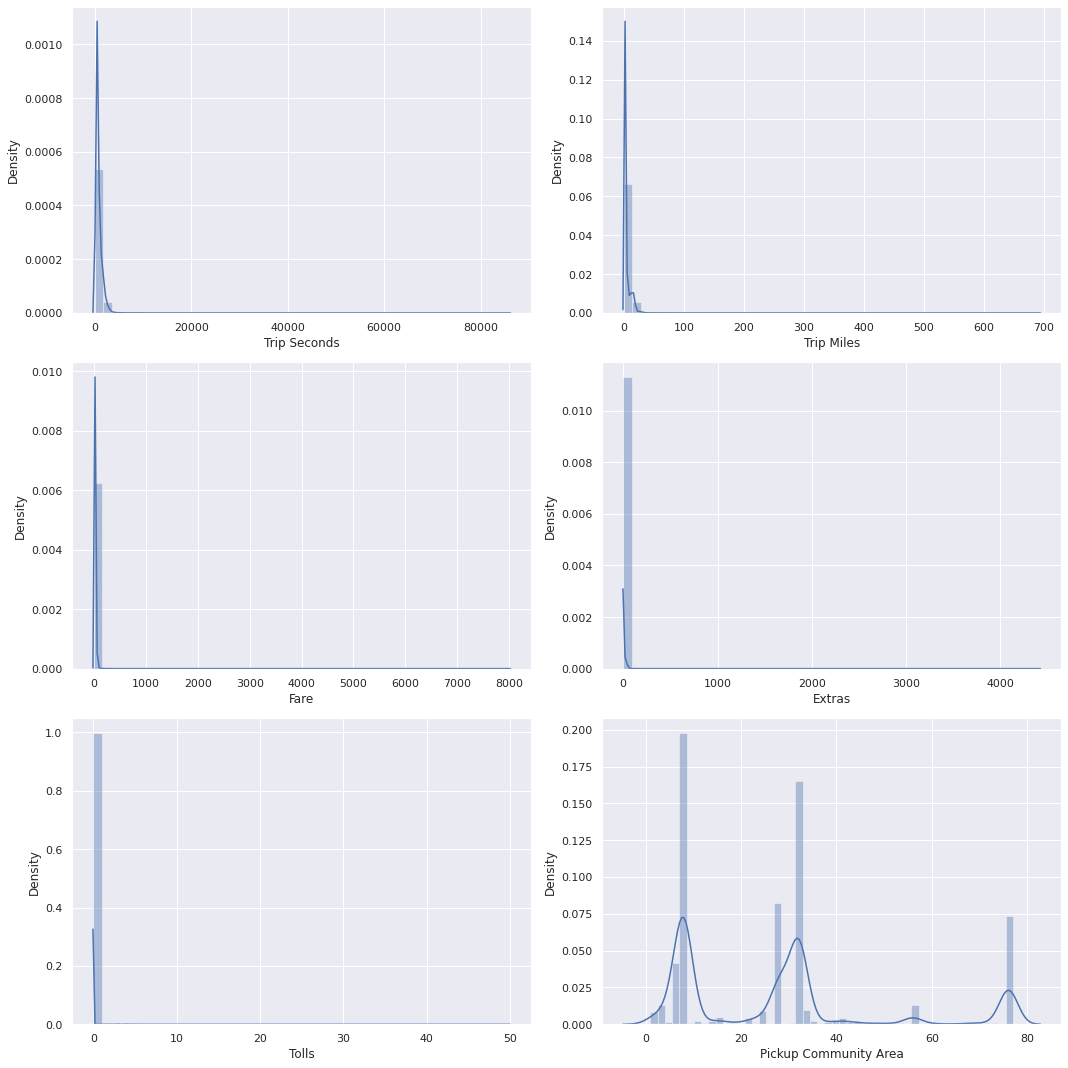

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(15,15))

sns.distplot(taxi['Trip Seconds'], ax=axes[0, 0])
sns.distplot(taxi['Trip Miles'], ax=axes[0, 1])
sns.distplot(taxi['Fare'], ax=axes[1, 0])
sns.distplot(taxi['Extras'], ax=axes[1, 1])
sns.distplot(taxi['Tolls'], ax=axes[2, 0])
sns.distplot(taxi['Pickup Community Area'], ax=axes[2, 1])

plt.tight_layout()

### Regression plots và Residual plots

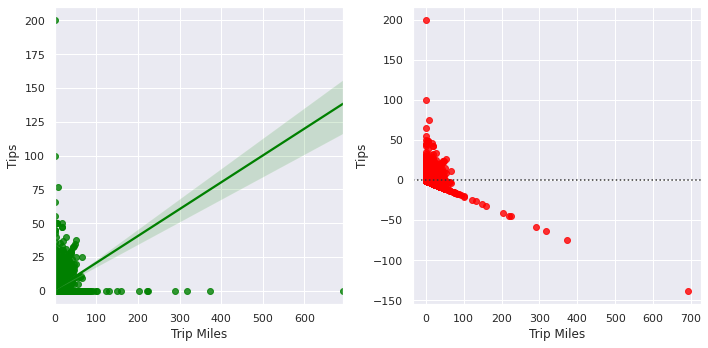

In [18]:

fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.regplot(taxi['Trip Miles'], taxi['Tips'], color='green', ax=axes[0]);
sns.residplot(taxi['Trip Miles'], taxi['Tips'], color='red', ax=axes[1]);

plt.tight_layout();

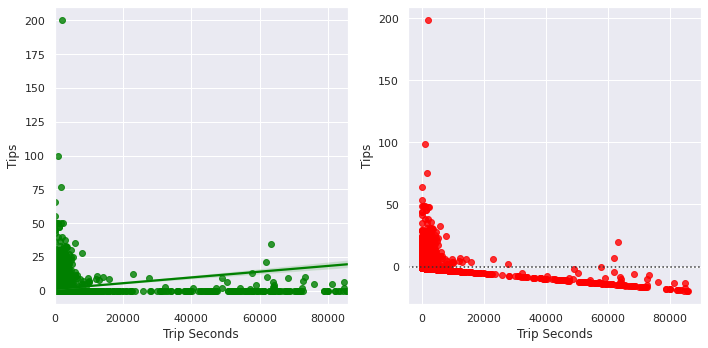

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.regplot(taxi['Trip Seconds'], taxi['Tips'], color='green', ax=axes[0]);
sns.residplot(taxi['Trip Seconds'], taxi['Tips'], color='red', ax=axes[1]);

plt.tight_layout();

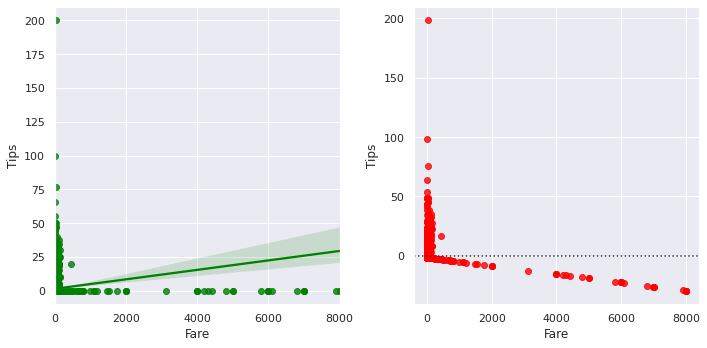

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.regplot(taxi['Fare'], taxi['Tips'], color='green', ax=axes[0]);
sns.residplot(taxi['Fare'], taxi['Tips'], color='red', ax=axes[1]);

plt.tight_layout();

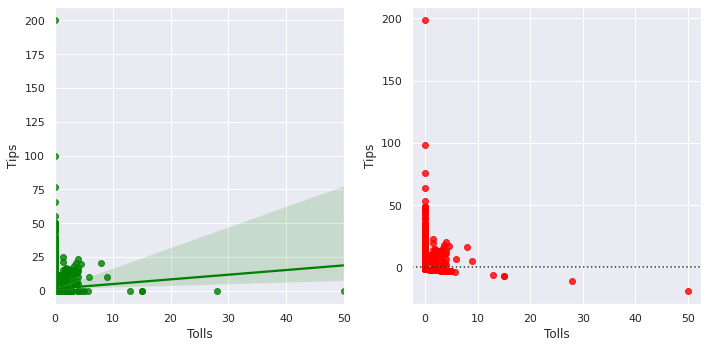

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.regplot(taxi['Tolls'], taxi['Tips'], color='green', ax=axes[0]);
sns.residplot(taxi['Tolls'], taxi['Tips'], color='red', ax=axes[1]);

plt.tight_layout();

In [22]:
data = taxi.drop(['Trip ID', 'Taxi ID'], axis=1).copy()
data.head()

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,240.0,0.60,NaN,NaN,8.0,8.0,5.00,0.00,0.0,0.0,5.00,Cash,Choice Taxi Association,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
1,01/01/2020 12:00:00 AM,01/01/2020 12:15:00 AM,600.0,1.00,1.703108e+10,1.703108e+10,8.0,8.0,7.25,3.00,0.0,1.0,11.25,Credit Card,Star North Management LLC,41.892042,-87.631864,POINT (-87.6318639497 41.8920421365),41.895033,-87.619711,POINT (-87.6197106717 41.8950334495)
2,01/01/2020 12:00:00 AM,01/01/2020 12:15:00 AM,383.0,0.69,1.703108e+10,1.703108e+10,8.0,8.0,5.75,0.00,0.0,0.0,5.75,Cash,Flash Cab,41.895033,-87.619711,POINT (-87.6197106717 41.8950334495),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935)
3,01/01/2020 12:00:00 AM,01/01/2020 12:30:00 AM,1861.0,3.16,1.703108e+10,1.703132e+10,8.0,32.0,16.00,3.60,0.0,1.5,21.60,Credit Card,City Service,41.899156,-87.626211,POINT (-87.6262105324 41.8991556134),41.877406,-87.621972,POINT (-87.6219716519 41.8774061234)
4,01/01/2020 12:00:00 AM,01/01/2020 12:15:00 AM,960.0,11.10,NaN,NaN,76.0,21.0,28.75,6.65,0.0,4.0,39.40,Credit Card,Star North Management LLC,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.938666,-87.711211,POINT (-87.7112105933 41.9386661962)


# Trực quan bản đồ Folium


In [23]:
!pip install folium
import folium
from folium import plugins
from folium.plugins import HeatMap

In [24]:
def generateBaseMap_Chicago(default_location=[41.8781, -87.6298], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

### Toàn bộ chuyến đi 

In [25]:
df_copy_pickup = data[['Pickup Centroid Latitude', 'Pickup Centroid Longitude']].copy()
df_copy_pickup['count'] = 1
base_map_pickup = generateBaseMap_Chicago()
HeatMap(data=df_copy_pickup[['Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'count']].groupby(['Pickup Centroid Latitude', 'Pickup Centroid Longitude']).sum().reset_index().values.tolist(), radius=12, max_zoom=15).add_to(base_map_pickup)
base_map_pickup


In [26]:
df_copy_Dropoff = data[['Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']].copy()
df_copy_Dropoff['count'] = 1
base_map_Dropoff = generateBaseMap_Chicago()
HeatMap(data=df_copy_Dropoff[['Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'count']].groupby(['Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']).sum().reset_index().values.tolist(), radius=12, max_zoom=15).add_to(base_map_Dropoff)
base_map_Dropoff

###Chuyến đi có TIPS

In [27]:
df_tip = data[data['Tips']!=0]
df_tip.shape

(81680, 21)

In [29]:
df_copy_pickup_tip = df_tip[['Pickup Centroid Latitude', 'Pickup Centroid Longitude']].copy()
df_copy_pickup_tip['count'] = 1
base_map_pickup_tip = generateBaseMap_Chicago()
HeatMap(data=df_copy_pickup_tip[['Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'count']].groupby(['Pickup Centroid Latitude', 'Pickup Centroid Longitude']).sum().reset_index().values.tolist(), radius=12, max_zoom=15).add_to(base_map_pickup_tip)
base_map_pickup_tip


In [28]:
df_copy_Dropoff_tip = df_tip[['Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']].copy()
df_copy_Dropoff_tip['count'] = 1
base_map_Dropoff_tip = generateBaseMap_Chicago()
HeatMap(data=df_copy_Dropoff_tip[['Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'count']].groupby(['Dropoff Centroid Latitude', 'Dropoff Centroid Longitude']).sum().reset_index().values.tolist(), radius=12, max_zoom=15).add_to(base_map_Dropoff_tip)
base_map_Dropoff_tip

# Xử lý dữ liệu

## Điền khuyết các giá trị trống

In [30]:
data.isna().sum(axis=0)

Trip Start Timestamp              0
Trip End Timestamp                0
Trip Seconds                     28
Trip Miles                        2
Pickup Census Tract           87901
Dropoff Census Tract          88842
Pickup Community Area         13204
Dropoff Community Area        18393
Fare                              0
Tips                              0
Tolls                             0
Extras                            0
Trip Total                        0
Payment Type                      0
Company                           0
Pickup Centroid Latitude      13031
Pickup Centroid Longitude     13031
Pickup Centroid Location      13031
Dropoff Centroid Latitude     17903
Dropoff Centroid Longitude    17903
Dropoff Centroid Location     17903
dtype: int64

In [31]:
!pip install haversine
import haversine as hs

def modify_miles(df):
  # Trip Second > 0 nhưng Trip Miles == 0 và có đầy đủ toạ độ Pickup location và Dropoff location
  fillbyDistance = list(df[~df['Pickup Centroid Location'].isna()][~df['Dropoff Centroid Location'].isna()][df['Trip Seconds']>0][df['Trip Miles']==0].index)
  for i in fillbyDistance:
    pick = (df.loc[i, 'Pickup Centroid Latitude'], df.loc[i, 'Pickup Centroid Longitude'])
    drop = (df.loc[i, 'Dropoff Centroid Latitude'], df.loc[i, 'Dropoff Centroid Longitude'])
    df.loc[i, 'Trip Miles'] = round(hs.haversine(pick, drop, unit=hs.Unit.MILES), 2)
  
  return df


In [32]:
def fill_area(df, tracts):
  pick_area_blank = list(df[(df['Pickup Community Area'].isna()) & (~df['Pickup Census Tract'].isna())].index)
  drop_area_blank = list(df[(df['Dropoff Community Area'].isna()) & (~df['Dropoff Census Tract'].isna())].index)

  for i in pick_area_blank:
    for trac_t in range(tracts.shape[0]):
      if df.loc[i, 'Pickup Census Tract'] == tracts.loc[trac_t, 'tract']:
        df.loc[i, 'Pickup Community Area'] = tracts.loc[trac_t, 'area']
        break

  for i in drop_area_blank:
    for trac_t in range(tracts.shape[0]):  
      if df.loc[i, 'Dropoff Census Tract'] == tracts.loc[trac_t, 'tract']:
        df.loc[i, 'Dropoff Community Area'] = tracts.loc[trac_t, 'area']
        break
      
  return df

In [33]:
def to_datetime(df):
  for col in ['start time', 'end time']:
      df[col] = pd.to_datetime(df[col], errors='coerce')

  return df

def fill_nan(df, tracts):
  df['Trip Miles'].fillna(0, inplace=True) # vì trường hợp này có đầy đủ các thuộc tính khác và Trip Seconds > 0 nên có thể dùng modify_miles

  # điền khuyết cho Trip Seconds
  blankIndex = list(df[df['Trip Seconds'].isna()].index)

  temp_df = df.copy()
  temp_df = to_datetime(temp_df)
  for i in blankIndex:
    df.loc[i, 'Trip Seconds'] = np.abs(temp_df.loc[i, 'start time'] - temp_df.loc[i, 'end time']).total_seconds()

  # thay thế và điền khuyết cho Trip Miles
  df = modify_miles(df)
  mean = round(np.mean(df['Trip Miles']), 2)
  fillbyMean = list(df[df['Trip Seconds']>0][df['Trip Miles']==0].index)
  for j in fillbyMean:
    df.loc[j, 'Trip Miles'] = mean

  # điền khuyết cho community area
  # df = fill_area(df, tracts)

  return df

## Tạo các đặc trưng mới

In [34]:
def time_rewrite(t):
  pm_hour = {'01':'13', '02':'14', '03':'15', '04':'16', '05':'17', '06':'18',
             '07':'19', '08':'20', '09':'21', '10':'22', '11':'23', '12':'12'}
  t = t.split(':')
  t[0] = pm_hour[t[0]]
  return ':'.join(i for i in t)

def time_stamp(timestamp):
  # dates = []
  time = []
  daytime = []
  
  for s in timestamp:
    temp = s.split()
    # dates.append(temp[0])
    if temp[2] == 'PM':
      time.append(time_rewrite(temp[1]))
    else:
      time.append(temp[1])

    daytime.append(temp[2])
  
  return time, daytime

In [35]:
def add_col(df):
  for pre, col in zip(['start', 'end'], ['Trip Start Timestamp', 'Trip End Timestamp']):
    time, daytime = time_stamp(df[col])
    # df[pre+' dates'] = dates
    df[pre+' time'] = time
    df[pre+' daytime'] = daytime
    
  df['start daytime'] = df['start daytime'].map({'PM': 'night', 'AM': 'morning'})
  df['end daytime'] = df['end daytime'].map({'PM': 'night', 'AM': 'morning'})

  return df

In [36]:
data = add_col(data)
data = fill_nan(data, tracts)

## Trích chọn đặc trưng

In [37]:
data.drop(['Trip Start Timestamp', 'Trip End Timestamp', 'Pickup Census Tract', 'Dropoff Census Tract',
           'Trip Total', 'Pickup Centroid Latitude', 'Pickup Centroid Longitude', 'Pickup Centroid Location',
           'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude', 'Dropoff Centroid Location', 'Company',
           'start time', 'end time'], axis=1, inplace=True)

In [38]:
data.dropna(inplace=True)

In [39]:
data.isna().sum()

Trip Seconds              0
Trip Miles                0
Pickup Community Area     0
Dropoff Community Area    0
Fare                      0
Tips                      0
Tolls                     0
Extras                    0
Payment Type              0
start daytime             0
end daytime               0
dtype: int64

In [40]:
data.to_csv('/content/drive/MyDrive/Colab Notebooks/Phân tích và trực quan dữ liệu/data_with_outliers.csv', index=0)

In [41]:
data.head()

,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Payment Type,start daytime,end daytime
0,240.0,0.60,8.0,8.0,5.00,0.00,0.0,0.0,Cash,morning,morning
1,600.0,1.00,8.0,8.0,7.25,3.00,0.0,1.0,Credit Card,morning,morning
2,383.0,0.69,8.0,8.0,5.75,0.00,0.0,0.0,Cash,morning,morning
3,1861.0,3.16,8.0,32.0,16.00,3.60,0.0,1.5,Credit Card,morning,morning
4,960.0,11.10,76.0,21.0,28.75,6.65,0.0,4.0,Credit Card,morning,morning


### Loại bỏ outliers

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Phân tích và trực quan dữ liệu/data_with_outliers.csv')

In [42]:
data.shape

(179554, 11)

In [43]:
data = data[~(data['Tips'] >= 200)]
data = data[data['Trip Miles'] <= 200]
data = data[data['Tolls'] <= 20]
data = data[data['Fare'] <= 20000]

In [44]:
data.shape

(179549, 11)

In [45]:
data.to_csv('/content/drive/MyDrive/Colab Notebooks/Phân tích và trực quan dữ liệu/data_without_outliers.csv', index=0)

### Độ tương quan

In [47]:
outlier_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Phân tích và trực quan dữ liệu/data_with_outliers.csv')

from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
cat_col = ['start daytime','end daytime','Payment Type']
for col in cat_col:
  outlier_data[f'{col}']=lb.fit_transform(outlier_data[f'{col}'])

outlier_data.head()

,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Payment Type,start daytime,end daytime
0,240.0,0.60,8.0,8.0,5.00,0.00,0.0,0.0,0,0,0
1,600.0,1.00,8.0,8.0,7.25,3.00,0.0,1.0,1,0,0
2,383.0,0.69,8.0,8.0,5.75,0.00,0.0,0.0,0,0,0
3,1861.0,3.16,8.0,32.0,16.00,3.60,0.0,1.5,1,0,0
4,960.0,11.10,76.0,21.0,28.75,6.65,0.0,4.0,1,0,0


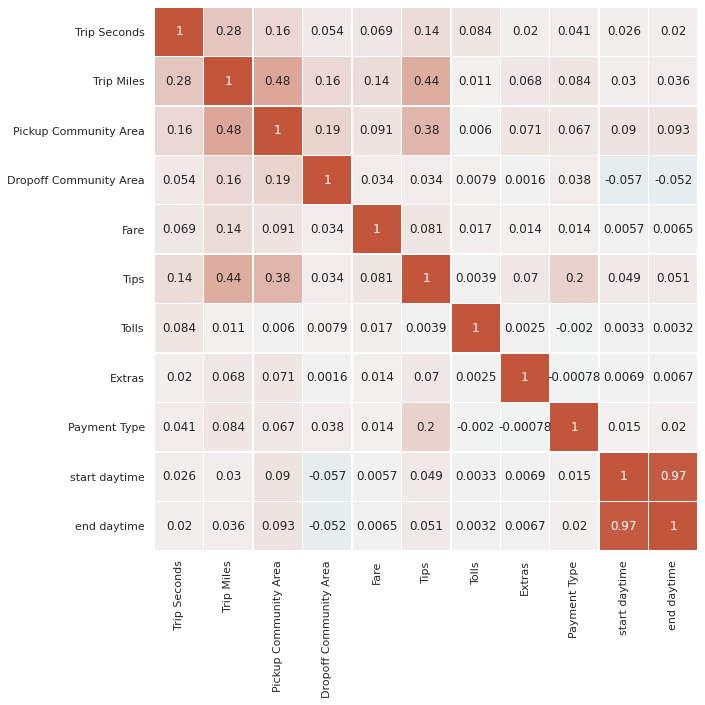

In [49]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(10, 10))

corr_tip = outlier_data.corr()
heat_map = sns.heatmap(corr_tip, cmap=cmap, vmax=1, vmin=-1, center=0, annot=True,
            cbar=False, square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [50]:
no_outlier_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Phân tích và trực quan dữ liệu/data_without_outliers.csv')

from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
cat_col = ['start daytime','end daytime','Payment Type']
for col in cat_col:
  no_outlier_data[f'{col}']=lb.fit_transform(no_outlier_data[f'{col}'])

no_outlier_data.head()

,Trip Seconds,Trip Miles,Pickup Community Area,Dropoff Community Area,Fare,Tips,Tolls,Extras,Payment Type,start daytime,end daytime
0,240.0,0.60,8.0,8.0,5.00,0.00,0.0,0.0,0,0,0
1,600.0,1.00,8.0,8.0,7.25,3.00,0.0,1.0,1,0,0
2,383.0,0.69,8.0,8.0,5.75,0.00,0.0,0.0,0,0,0
3,1861.0,3.16,8.0,32.0,16.00,3.60,0.0,1.5,1,0,0
4,960.0,11.10,76.0,21.0,28.75,6.65,0.0,4.0,1,0,0


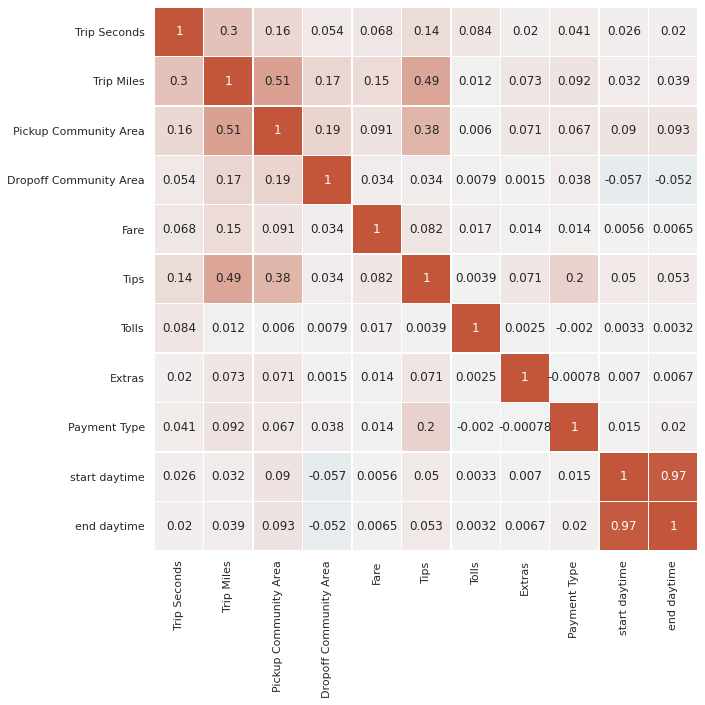

In [51]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(10, 10))

corr_tip = no_outlier_data.corr()
heat_map = sns.heatmap(corr_tip, cmap=cmap, vmax=1, vmin=-1, center=0, annot=True,
            cbar=False, square=True, linewidths=.5, cbar_kws={"shrink": .5});